In [30]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
import copy
import random
import importlib
import algos as al
import imageio

In [31]:
def generate_sf_graph(n):
    G = nx.scale_free_graph(n=n,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    components = list(nx.connected_components(G))
    while len(components) > 1:
        G.add_edge(components[0].pop(), components[1].pop())
        components = list(nx.connected_components(G))
    return G

In [32]:
def add_weights_to_edges_from_dict(graph, weights_dict):
    for edge, weight in weights_dict.items():
        if graph.has_edge(*edge):
            graph[edge[0]][edge[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        elif graph.has_edge(*reversed(edge)):
            graph[reversed(edge)[0]][reversed(edge)[1]]['weight'] = np.sqrt( np.log(1/weight)) *10
        else:
            print(f"Edge {edge} not found in the graph.")

In [33]:
def visualize_graph(G):
    pos = nx.spring_layout(G)  # You can use other layouts as well

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='black', width=1.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)

    # Draw node labels
    node_labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

    plt.title("Graph Visualization")
    plt.show()

In [34]:
def generate_sf_graph(n):
    G = nx.scale_free_graph(n=n,alpha=.41).to_undirected()
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    components = list(nx.connected_components(G))
    while len(components) > 1:
        G.add_edge(components[0].pop(), components[1].pop())
        components = list(nx.connected_components(G))
    return G

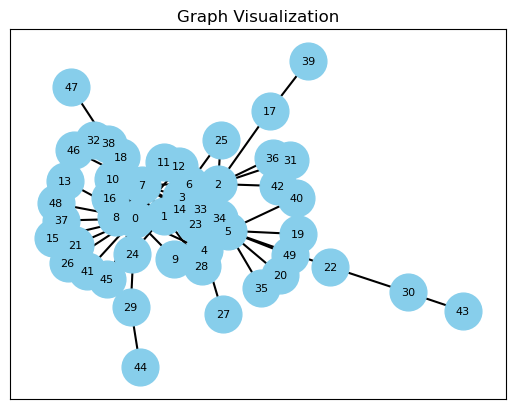

In [35]:
G = generate_sf_graph(50)
visualize_graph(G)

In [38]:
def probabilistic_walk(graph):
    visited_edges = set()
    walked_edges = []
    nodes = list(graph.nodes())

    # Compute PageRank
    pagerank_scores = nx.pagerank(graph)

    current_node = random.choice(nodes)
    while len(visited_edges) < graph.number_of_edges():
        neighbors = list(graph.neighbors(current_node))
        
        if not neighbors:
            print("No available neighbors")
            break

        # Compute probability using edge weight and PageRank
        weights = [
            pagerank_scores[neighbor] 
            for neighbor in neighbors
        ]

        # Normalize probabilities
        total_weight = sum(weights)
        if total_weight == 0:
            print("Encountered zero total weight")
            break

        probabilities = [w / total_weight for w in weights]

        next_node = random.choices(neighbors, weights=probabilities)[0]
        edge = (min(current_node, next_node), max(current_node, next_node))

        visited_edges.add(edge)
        walked_edges.append(edge)

        # Update edge weight
        graph[current_node][next_node]['weight'] = np.sqrt(graph[current_node][next_node]['weight'])

        current_node = next_node

    return walked_edges

In [36]:
def initialize_edge_weights(graph):
    """Set all edge weights to 0 for visualization."""
    for u, v in graph.edges():
        graph[u][v]['weight'] = 0

In [37]:
def get_highest_degree_node(graph):
    """Return the node with the highest degree in the graph."""
    degrees = dict(graph.degree())
    return max(degrees, key=degrees.get)

In [45]:
def multiple_probabilistic_walks(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    pagerank_scores = nx.pagerank(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                1/pagerank_scores[neighbor] + 0.000000001
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    for i in range (90):
        snapshot = copy.deepcopy(snapshots[-1])
        snapshots.append(snapshot)
    
    return snapshots 

In [39]:
def visualize_graph(snapshot, ax, max_weight, starting_node=None):
    """Visualize a single snapshot of the graph with edge opacity and color based on current weight."""
    ax.clear()  # Clear the previous frame
    pos = nx.spring_layout(snapshot, seed=42, weight=None)  # Fixed layout for consistency
    
    # Get edge weights for the current snapshot
    edge_weights = np.array([snapshot[u][v]['weight'] for u, v in snapshot.edges()])

    # Create a colormap for edge weights
    cmap = plt.cm.plasma
    min_weight = 0.1  # Minimum weight to ensure edges are visible
    weight_factor = 3  # Adjust this factor to enhance color intensity
    
    # Minimum and maximum opacity values
    min_opacity = 0.1  # Set a minimum opacity for visibility
    max_opacity = 1.0  # Fully opaque for the highest weights

    # Scale weights for color mapping
    edge_weights = np.maximum(edge_weights, min_weight)  # Avoid weights below minimum
    
    # Normalize edge weights for color and opacity calculation
    scaled_weights = edge_weights * weight_factor  # Scale weights for color mapping
    
    # Calculate opacity based on edge weights relative to max weight in the last snapshot
    opacities = min_opacity + (edge_weights / max_weight) * (max_opacity - min_opacity)
    
    # Get colors from the colormap and apply opacity
    edge_colors = [(*cmap(weight / max_weight)[:3], opacity) 
                   for weight, opacity in zip(scaled_weights, opacities)]

    # Draw edges with colors and transparency based on weights
    nx.draw_networkx_edges(snapshot, pos, edge_color=edge_colors, width=2, ax=ax)

    # Draw nodes, differentiating the starting node with a different color
    node_colors = ['red' if node == starting_node else 'skyblue' for node in snapshot.nodes()]
    nx.draw_networkx_nodes(snapshot, pos, node_color=node_colors, node_size=100, ax=ax)

    # Turn off the axis
    plt.axis('off')


In [40]:
def animate_walks(snapshots, save_gif=True, filename="multiple_walks.gif", fps=5):
    """Animate the snapshots of graph walks and save as a GIF if desired."""
    # Create a figure for visualization
    fig, ax = plt.subplots(figsize=(18, 8), facecolor='#3e3e3e')
    last_snapshot = snapshots[-1]
    max_weight = max([last_snapshot[u][v]['weight'] for u, v in last_snapshot.edges()])
    starting_node = get_highest_degree_node(snapshots[0]) 
    
    # Update function to visualize each snapshot
    def update(frame):
        ax.clear()  # Clear the previous frame
        visualize_graph(snapshots[frame], ax, max_weight,starting_node)  # Visualize the current snapshot
        plt.title(f"Frame {frame + 1}", color='white')  # Update title with current step number
    
    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(snapshots), interval=300, repeat=False)

    # Show or save the animation
    if save_gif:
        writer = PillowWriter(fps=fps)
        ani.save(filename, writer=writer)
        print(f"Animation saved as {filename}")
    else:
        plt.show()

Graph with 200 nodes and 241 edges
Animation saved as pageRanke_new.gif


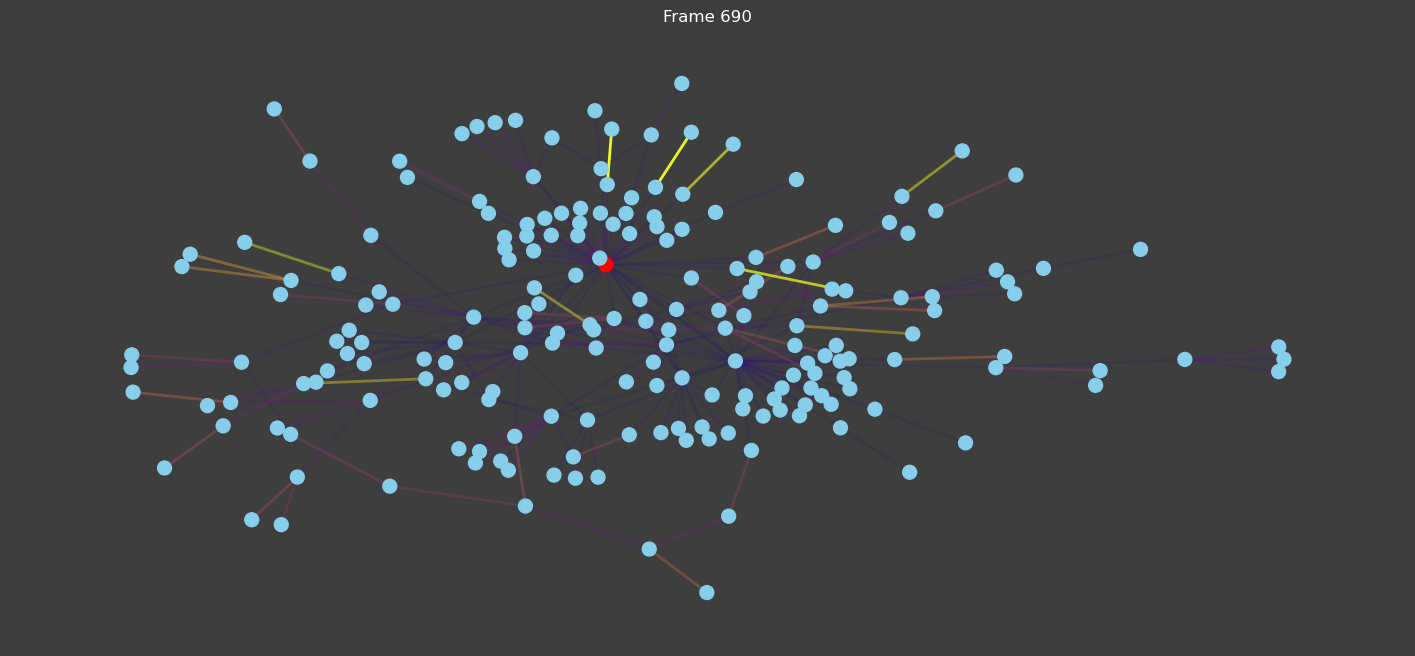

In [46]:
G = al.generate_sf_graph(200)
snapshots = multiple_probabilistic_walks(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="pageRanke_new.gif",fps=37)

In [52]:
def multiple_probabilistic_walks_betweenness(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    bc_centralities = nx.betweenness_centrality(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                1/(bc_centralities[neighbor] +0.0000001)
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    for i in range (90):
        snapshot = copy.deepcopy(snapshots[-1])
        snapshots.append(snapshot)
    
    return snapshots 

Graph with 200 nodes and 253 edges
Animation saved as betweenness_new.gif


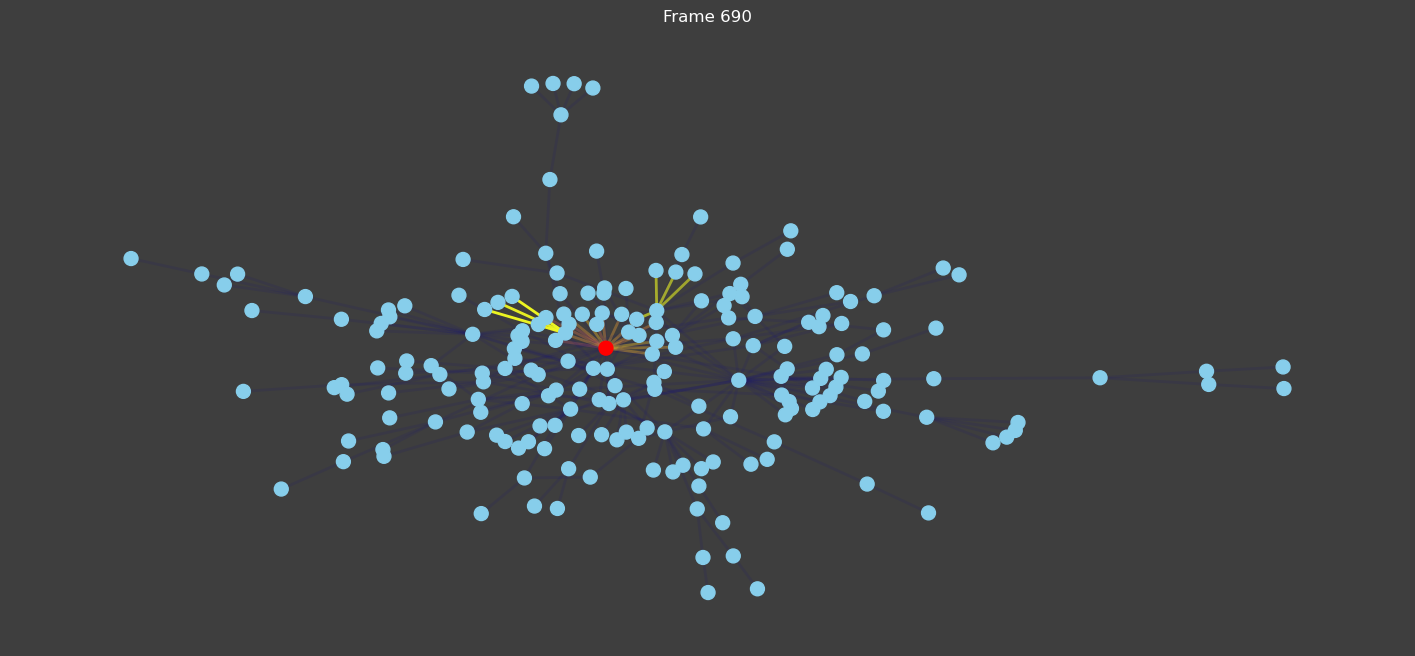

In [ ]:
G = al.generate_sf_graph(200)
snapshots = multiple_probabilistic_walks_betweenness(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="betweenness_new.gif",fps=37)

In [56]:
def multiple_probabilistic_walks_degree(graph, num_walks, steps):
    walked_edges_per_step = [[] for _ in range(steps)]  # Store walked edges per step
    edge_step_count = {edge: 0 for edge in graph.edges()}  # Track how many times each edge is stepped on
    starting_node = get_highest_degree_node(graph)  # Start walks from the highest degree node
    dc_centralities = nx.degree_centrality(graph)
    for _ in range(num_walks):
        current_node = starting_node
        
        for i in range(steps):
            neighbors = list(graph.neighbors(current_node))
            weights = [
                1/(dc_centralities[neighbor])
                for neighbor in neighbors
            ]
    
            # Normalize probabilities
            total_weight = sum(weights)
            if total_weight == 0:
                print("Encountered zero total weight")
                break
            
            probabilities = [w / total_weight for w in weights]
    
            next_node = random.choices(neighbors, weights=probabilities)[0]
            edge = (min(current_node, next_node), max(current_node, next_node))

            walked_edges_per_step[i].append(edge)
            edge_step_count[edge] += 1  # Update step count for the edge


            current_node = next_node

    v_graph = copy.deepcopy(graph)
    print(v_graph)
    initialize_edge_weights(v_graph)
    snapshots = []
    for  edges_in_step in walked_edges_per_step:
        for edge in edges_in_step:
            u, v = edge
            v_graph[u][v]['weight'] += 1 
        snapshot = copy.deepcopy(v_graph)
        snapshots.append(snapshot)
        
    for i in range (90):
        snapshot = copy.deepcopy(snapshots[-1])
        snapshots.append(snapshot)
    
    return snapshots 

Graph with 200 nodes and 259 edges
Animation saved as degree_new.gif


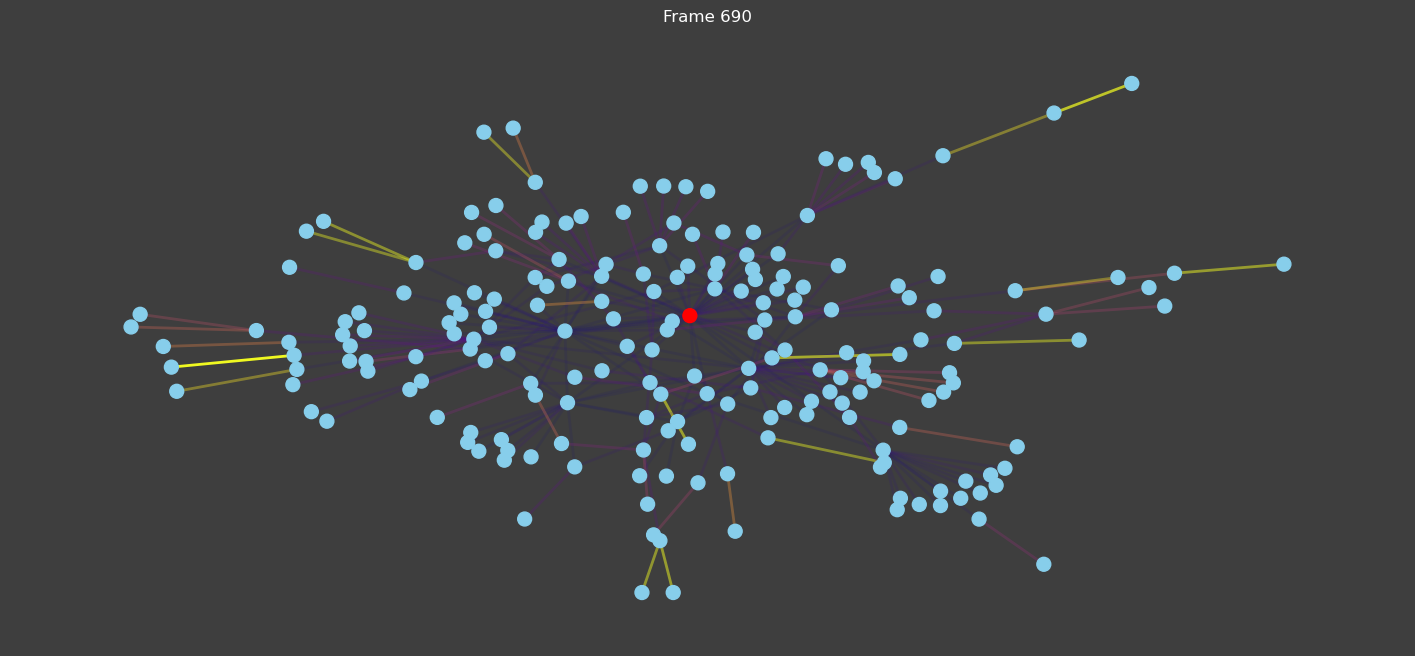

In [57]:
G = al.generate_sf_graph(200)
snapshots = multiple_probabilistic_walks_degree(G, num_walks=10, steps=600)
animate_walks(snapshots,  filename="degree_new.gif",fps=37)